<a id='notebook-top'></a>
This notebook plots the intensity and Doppler shift maps of the east and west upflow region in Fe XII 19.51 nm and Ne VIII 77.04 lines, observed by Hinode/EIS and SolO/SPICE, respectively. The east region (outlined by the purple contour) is defined by blueshifts greater than - 5 km/s in the Fe XII 19.51 nm line. The west region, also defined with blueshifts greater than -5 km/s is illustrated by the green contour. You may also see how these regions are defined throughout the notebook.
Link to [Figure 3](#figure-3).

Note: The internal hyperlink only works on [GitHub Pages](https://yjzhu-solar.github.io/EIS_DKIST_SolO/eis_eui_upflow_ipynb_html/eis_spice_doppler.html) or [nbviewer](https://nbviewer.org/github/yjzhu-solar/EIS_DKIST_SolO/blob/master/ipynb/ms_eis_eui_upflow/eis_spice_doppler.ipynb). Do not click when viewing the notebook on GitHub.

In [6]:
import eispac
import numpy as np
import matplotlib.pyplot as plt
import sunpy
import sunpy.map
from sunpy.coordinates import (propagate_with_solar_surface,
                               get_horizons_coord)
import pandas as pd
import os
import astropy
import astropy.units as u
import astropy.coordinates
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.constants as const
from regions import (PolygonSkyRegion,EllipsePixelRegion, PixCoord, Regions)
import shapely
from scipy.io import readsav
from scipy.interpolate import LinearNDInterpolator
from astropy.visualization import (ImageNormalize, SqrtStretch, 
                                   AsinhStretch, LogStretch)
from eis_straylight import calc_short_range_stray_light, calc_long_range_stray_light_aia_eis, coalign_eis_aia
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc_context, rcParams
import matplotlib.patheffects as path_effects
import cmcrameri.cm as cmcm
from fancy_colorbar import plot_colorbar
import re
from glob import glob
from sunraster.instr.spice import read_spice_l2_fits

In [3]:
ms_style_dict = {'text.usetex': True, 'font.family': 'serif', 'axes.linewidth': 1.2,
                 'xtick.major.width': 1.2, 'xtick.major.size': 4,
                 'ytick.major.width': 1.2, 'ytick.major.size': 4,
                 'xtick.minor.width': 1.2, 'xtick.minor.size': 2,
                 'ytick.minor.width': 1.2, 'ytick.minor.size': 2,
                 'xtick.direction': 'in', 'ytick.direction': 'in',
                 'text.latex.preamble': r'\usepackage[T1]{fontenc}'
                 r'\usepackage{amsmath}' r'\usepackage{siunitx}'
                 r'\sisetup{detect-all=True}'}

In [4]:
eis_195_intmap_shift_1024 = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_intmap_shift.fits")
eis_195_intmap_shift_1024.plot_settings['aspect'] = eis_195_intmap_shift_1024.scale.axis2/eis_195_intmap_shift_1024.scale.axis1
# eis_195_intmap_shift_1024.plot_settings['norm'] = ImageNormalize(vmin=0,vmax=1e3)
eis_195_intmap_shift_1024.plot_settings['cmap'] = 'sdoaia193'
eis_195_velmap_shift_1024 = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_velmap_shift.fits")
eis_195_velmap_shift_1024.plot_settings['aspect'] = eis_195_velmap_shift_1024.scale.axis2/eis_195_velmap_shift_1024.scale.axis1
eis_195_velmap_shift_1024.plot_settings['norm'] = ImageNormalize(vmin=-20,vmax=20)
eis_195_velmap_shift_1024.plot_settings['cmap'] = 'coolwarm'

In [15]:
cs_regions_eis_1024 = Regions.read("../../sav/regions/eis_1024_east_pixel.reg")[0].to_sky(eis_195_intmap_shift_1024.wcs)

In [16]:
eis_195_intmap_shift_1024_crop = eis_195_intmap_shift_1024.submap(SkyCoord(eis_195_intmap_shift_1024.bottom_left_coord.Tx,
                                                                           100*u.arcsec, frame=eis_195_intmap_shift_1024.coordinate_frame),
                                                                  top_right=SkyCoord(eis_195_intmap_shift_1024.top_right_coord.Tx,
                                                                            400*u.arcsec, frame=eis_195_intmap_shift_1024.coordinate_frame))
eis_195_intmap_shift_1024_crop.plot_settings['norm'] = ImageNormalize(vmin=np.nanpercentile(eis_195_intmap_shift_1024_crop.data, 1),
                                                                      vmax=np.nanpercentile(eis_195_intmap_shift_1024_crop.data, 99),
                                                                      stretch=AsinhStretch())

eis_195_velmap_shift_1024_crop = eis_195_velmap_shift_1024.submap(SkyCoord(eis_195_velmap_shift_1024.bottom_left_coord.Tx,
                                                                            100*u.arcsec, frame=eis_195_velmap_shift_1024.coordinate_frame),
                                                                    top_right=SkyCoord(eis_195_velmap_shift_1024.top_right_coord.Tx,
                                                                            400*u.arcsec, frame=eis_195_velmap_shift_1024.coordinate_frame))

In [17]:
spice_hri_NeVIII_intmap_1024 = sunpy.map.Map("../../src/coalign_map/20221024/spice_NeVIII_intmap_derot_repro_hrifov.fits")
spice_hri_NeVIII_intmap_1024 = sunpy.map.Map(spice_hri_NeVIII_intmap_1024.data*1e3, spice_hri_NeVIII_intmap_1024.meta) # W/m^2 -> erg/cm^2/s
spice_hri_NeVIII_velmap_1024 = sunpy.map.Map("../../src/coalign_map/20221024/spice_NeVIII_velmap_derot_repro_hrifov.fits")
spice_hri_NeVIII_intmap_1024 = spice_hri_NeVIII_intmap_1024.submap([300,20]*u.pix, top_right=[1750, 1300]*u.pix)
spice_hri_NeVIII_velmap_1024 = spice_hri_NeVIII_velmap_1024.submap([300,20]*u.pix, top_right=[1750, 1300]*u.pix)
spice_hri_NeVIII_intmap_1024.plot_settings['norm'] = ImageNormalize(vmin=np.nanpercentile(spice_hri_NeVIII_intmap_1024.data, 0.3),
                                                                    vmax=np.nanpercentile(spice_hri_NeVIII_intmap_1024.data, 99.7),
                                                                    stretch=AsinhStretch())
spice_hri_NeVIII_intmap_1024.plot_settings['cmap'] = 'sdoaia171'
spice_hri_NeVIII_intmap_1024.plot_settings['aspect'] = spice_hri_NeVIII_intmap_1024.scale.axis2/spice_hri_NeVIII_intmap_1024.scale.axis1
spice_hri_NeVIII_velmap_1024.plot_settings['norm'] = ImageNormalize(vmin=-30,vmax=30)
spice_hri_NeVIII_velmap_1024.plot_settings['cmap'] = 'coolwarm'

In [18]:
spice_1024_cube = read_spice_l2_fits('../../src/SPICE/20221024/solo_L2_spice-n-ras_20221024T231535_V07_150995398-000_coalign.fits')
spice_1024_window_example = spice_1024_cube['Ne VIII 770 - Peak']

Set MJD-OBS to 59876.969164 from DATE-OBS.
Set MJD-BEG to 59876.969164 from DATE-BEG.
Set MJD-AVG to 59877.036108 from DATE-AVG.
Set MJD-END to 59877.103050 from DATE-END'. [astropy.wcs.wcs]


In [19]:
def get_ax_size(ax, fig, return_ratio=True):
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height
    width *= fig.dpi
    height *= fig.dpi
    if return_ratio:
        return height/width
    else:
        return width, height

In [39]:
height_width_eis = np.array(eis_195_intmap_shift_1024_crop.data.shape)*np.array((eis_195_intmap_shift_1024_crop.scale.axis2.to_value(),
                                                              eis_195_intmap_shift_1024_crop.scale.axis1.to_value()))

In [40]:
height_width_spice = np.array(spice_hri_NeVIII_intmap_1024.data.shape)*np.array((spice_hri_NeVIII_intmap_1024.scale.axis2.to_value(),
                                                             spice_hri_NeVIII_intmap_1024.scale.axis1.to_value()))

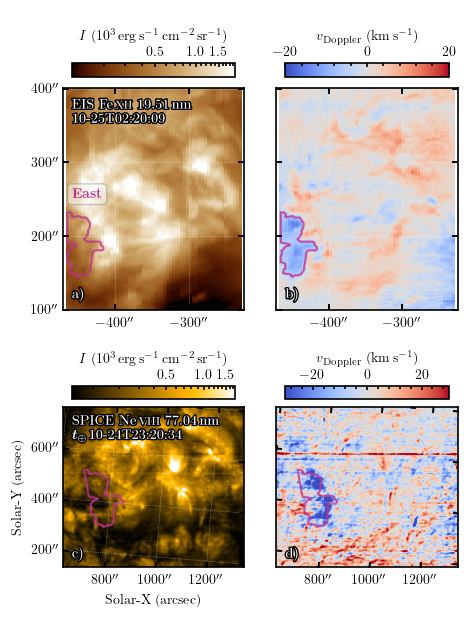

In [44]:
with rc_context(ms_style_dict):
    fig = plt.figure(figsize=(4.8,6),layout='constrained')

    gs1 = fig.add_gridspec(2, 2, figure=fig, height_ratios=[height_width_eis[0], height_width_spice[0]/height_width_spice[1]*height_width_eis[1]],
                    width_ratios=[1,1],
                    hspace=0.01)
    
    ax1 = fig.add_subplot(gs1[0,0], projection=eis_195_intmap_shift_1024_crop)
    im1 = eis_195_intmap_shift_1024_crop.plot(axes=ax1, title=None)
    cs_regions_eis_1024.to_pixel(eis_195_intmap_shift_1024_crop.wcs).plot(ax=ax1, edgecolor='#C1328E', lw=1.5,alpha=0.8)

    clb1, clb_ax1 = plot_colorbar(im1, ax1, 
                                  bbox_to_anchor=(0.05,1.05,0.9,0.06), orientation='horizontal',
                                  fontsize=10,scilimits=(0,0))
    fig.canvas.draw_idle()
    clb1.set_label(r'$I\ \mathrm{{({:}\,erg\,s^{{-1}}\,cm^{{-2}}\,sr^{{-1}})}}$'.format(re.search('\\\\mathdefault{(.*)}\\\\',
                                                                                    clb_ax1.xaxis.get_offset_text().get_text()).group(1)))
    
    ax1.text(0.05, 0.04, r'\textbf{a)}', transform=ax1.transAxes, fontsize=10, va='bottom',
             ha='left', color='white', path_effects=[path_effects.Stroke(linewidth=2, foreground='black'),
                                                path_effects.Normal()])
    
    ax1.text(0.05, 0.95, r'\textbf{EIS Fe\,\textsc{xii} 19.51\,nm}' 
                         "\n" + r'\textbf{{{}}}\,'.format(eis_195_intmap_shift_1024_crop.date.isot[5:-4]),
             transform=ax1.transAxes, fontsize=10, va='top', ha='left',linespacing=1.2,
             color='white', path_effects=[path_effects.Stroke(linewidth=2, foreground='black'),
                                          path_effects.Normal()])
    
    ax1.text(0.05, 0.55, r"\textbf{East}", transform=ax1.transAxes, fontsize=10, va='top', ha='left',
             color='#C1328E',bbox=dict(boxstyle="round", fc="w", ec="#91989F",alpha=0.5))
    
    
    ax2 = fig.add_subplot(gs1[0,1], projection=eis_195_velmap_shift_1024_crop)
    im2 = eis_195_velmap_shift_1024_crop.plot(axes=ax2, title=None)
    cs_regions_eis_1024.to_pixel(eis_195_velmap_shift_1024_crop.wcs).plot(ax=ax2, edgecolor='#C1328E', lw=1.5,alpha=0.8)

    clb2, clb_ax2 = plot_colorbar(im2, ax2,
                                    bbox_to_anchor=(0.05,1.05,0.9,0.06), orientation='horizontal',
                                    fontsize=10,scilimits=(0,2),title=r'$v_{\rm Doppler}\ \mathrm{(km\,s^{-1})}$')
    
    ax2.text(0.05, 0.04, r'\textbf{b)}', transform=ax2.transAxes, fontsize=10, va='bottom',
                ha='left', color='white', path_effects=[path_effects.Stroke(linewidth=2, foreground='black'),
                                                    path_effects.Normal()])
    
    
    ax5 = fig.add_subplot(gs1[1,0], projection=spice_hri_NeVIII_intmap_1024)
    im5 = spice_hri_NeVIII_intmap_1024.plot(axes=ax5,title=None)
    with propagate_with_solar_surface(rotation_model='rigid'):
        cs_regions_eis_1024.to_pixel(spice_hri_NeVIII_intmap_1024.wcs).plot(ax=ax5, edgecolor='#C1328E', lw=1.5,alpha=0.8)

    ax5.set_xlabel(r'Solar-X (arcsec)')
    ax5.set_ylabel(r'Solar-Y (arcsec)')

    fig.canvas.draw_idle()

    clb5_bbox_height = 0.06*get_ax_size(ax1, fig)/get_ax_size(ax5, fig)

    clb5, clb_ax5 = plot_colorbar(im5, ax5,
                                    bbox_to_anchor=(0.05,1.05,0.9,clb5_bbox_height), orientation='horizontal',
                                    fontsize=10,scilimits=(0,0))
    
    clb5.set_label(r'$I\ \mathrm{{({:}\,erg\,s^{{-1}}\,cm^{{-2}}\,sr^{{-1}})}}$'.format(re.search('\\\\mathdefault{(.*)}\\\\',
                                                                                    clb_ax1.xaxis.get_offset_text().get_text()).group(1)))
    
    ax5.text(0.05, 0.04, r'\textbf{c)}', transform=ax5.transAxes, fontsize=10, va='bottom',
                ha='left', color='white', path_effects=[path_effects.Stroke(linewidth=2, foreground='black'),
                                                    path_effects.Normal()])
    
    ax5.text(0.05, 0.95, r'\textbf{SPICE Ne\,\textsc{viii} 77.04\,nm}'
                            "\n" + r'$\boldsymbol{{t_\oplus}}\,$\textbf{{{}}}'.format(spice_1024_window_example.meta['DATE_EAR'][5:-4]),
            transform=ax5.transAxes,
            va='top', ha='left', fontsize=10, color='white', linespacing=1.2, 
            path_effects=[path_effects.Stroke(linewidth=2, foreground='black'),
                          path_effects.Normal()])

    # ax5.text(0.05, 0.95, r'\textbf{EIS Fe\,\textsc{xii} 19.51\,nm}' 
    #                      "\n" + r'\textbf{{{}}}\,'.format(eis_195_intmap_shift_1024_crop.date.isot[5:-4]),
    #          transform=ax5.transAxes, fontsize=10, va='top', ha='left',linespacing=1.2,
    #          color='white', path_effects=[path_effects.Stroke(linewidth=2, foreground='black'),
    #                                       path_effects.Normal()])

    ax6 = fig.add_subplot(gs1[1,1], projection=spice_hri_NeVIII_velmap_1024)
    im6 = spice_hri_NeVIII_velmap_1024.plot(axes=ax6,title=None)
    with propagate_with_solar_surface(rotation_model='rigid'):
        cs_regions_eis_1024.to_pixel(spice_hri_NeVIII_velmap_1024.wcs).plot(ax=ax6, edgecolor='#C1328E', lw=1.5,alpha=0.8)
    
    clb6, clb_ax6 = plot_colorbar(im6, ax6,
                                    bbox_to_anchor=(0.05,1.05,0.9,clb5_bbox_height), orientation='horizontal',
                                    fontsize=10,scilimits=(0,2),title=r'$v_{\rm Doppler}\ \mathrm{(km\,s^{-1})}$')
    
    ax6.text(0.05, 0.04, r'\textbf{d)}', transform=ax6.transAxes, fontsize=10, va='bottom',
                ha='left', color='white', path_effects=[path_effects.Stroke(linewidth=2, foreground='black'),
                                                    path_effects.Normal()])

    for ax_ in (ax1,ax2,ax6,):
        ax_.set_title(' ')
        ax_.coords[0].axislabels.set_visible(False)
        ax_.coords[1].axislabels.set_visible(False)
        ax_.coords[0].set_ticks(number=3)
        ax_.coords[1].set_ticks(number=3)
    
    for clb_ax_ in (clb_ax1,clb_ax2, clb_ax5, clb_ax6):
        clb_ax_.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False,
                            length=3)
        clb_ax_.xaxis.tick_top()
        clb_ax_.xaxis.set_label_position('top') 
        offset_text = clb_ax_.xaxis.get_offset_text()
        if offset_text is not None:
            offset_text.set_visible(False)
            # offset_text_pos = offset_text.get_position()
            # offset_text.set_position((offset_text_pos[0]+0.17, offset_text_pos[1]))
            # clb_ax_.xaxis.OFFSETTEXTPAD = -9

    for ax_ in (ax2,ax6,):
        ax_.coords[1].set_ticklabel_visible(False)

    # in maptlotlib 3.9 the rasterization of colorbar will be misplaced in PDF 
    # backend by setting `bbox_inches='tight'` with `inset_axes` from 
    #`mpl_toolkits.axes_grid1.inset_locator` module
    # see github issues:
    # https://github.com/matplotlib/matplotlib/issues/28549
    # https://github.com/matplotlib/matplotlib/issues/27763

    fig.get_layout_engine().set(w_pad=1/72., h_pad=1/72., hspace=0,
                        wspace=0)
    
    fig.savefig("../../figs/test_figs/annual_report_doppler.pdf", dpi=300, bbox_inches='tight')
    fig.savefig("../../figs/test_figs/annual_report_doppler.png", dpi=300, bbox_inches='tight')

    plt.show()